# HANDS-ON PRACTICE SESSION 3: PRACTICAL CONSIDERATIONS

SO Basics of Neural Networks 2025 school at the IAA-CSIC. Oct 2025.  
Eduardo Sánchez Karhunen  (fesanchez@us.es)  
Dept. of CS and Artificial Intelligence. University of Seville. Spain.  

### Introduction

In the last session, a CNN was designed to tackle the Galaxy10 classification problem. The obtained accuracy on the test dataset was around 62%.

In this third practice we are going to apply some improvements to our CNNs. Basically:
* Early Stopping
* Drop-out
* Data-Augmentation

The final goal of these techniques is to obtain an improvement in the network classification results, fighting against the overfitting.

### 1. Loading libraries

In [1]:
import numpy as np
import h5py
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# only execute this lines if the following error appears
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Exercise 0: Dataset preparation

As in the previous session, download the dataset to your local disk.

In [3]:
# LINUX
!wget http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

# WINDOWS
# !curl "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5" --output Galaxy10.h5

--2025-10-15 14:48:13--  http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5 [following]
--2025-10-15 14:48:13--  https://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M)
Saving to: ‘Galaxy10.h5’

Galaxy10.h5         100%[===================>] 200.50M  50.0MB/s    in 4.5s    

2025-10-15 14:48:18 (44.6 MB/s) - ‘Galaxy10.h5’ saved [210234548/210234548]



Convert the downloaded h5 files into two numpy arrays containing images and labels.

In [4]:
hf = h5py.File('Galaxy10.h5', 'r')
labels, images = hf.get('ans')[()], hf.get('images')[()]

To make our results more interpretable, let's define a list of the human-readable names for the 10 Galaxy10 classes.

In [5]:
class_names = [
    "Disk, Face-on, No Spiral",
    "Smooth, Completely round",
    "Smooth, in-between round",
    "Smooth, Cigar shaped",
    "Disk, Edge-on, Rounded Bulge",
    "Disk, Edge-on, Boxy Bulge",
    "Disk, Edge-on, No Bulge",
    "Disk, Face-on, Tight Spiral",
    "Disk, Face-on, Medium Spiral",
    "Disk, Face-on, Loose Spiral"
]

Check the shape of the dataset.

In [6]:
n_images, *shape, n_channels = images.shape
print(f"number of images: {n_images}")
print(f"shape of each image: {shape}")
print(f"number of channels: {n_channels}")

number of images: 21785
shape of each image: [69, 69]
number of channels: 3


Let's explore again the datatet

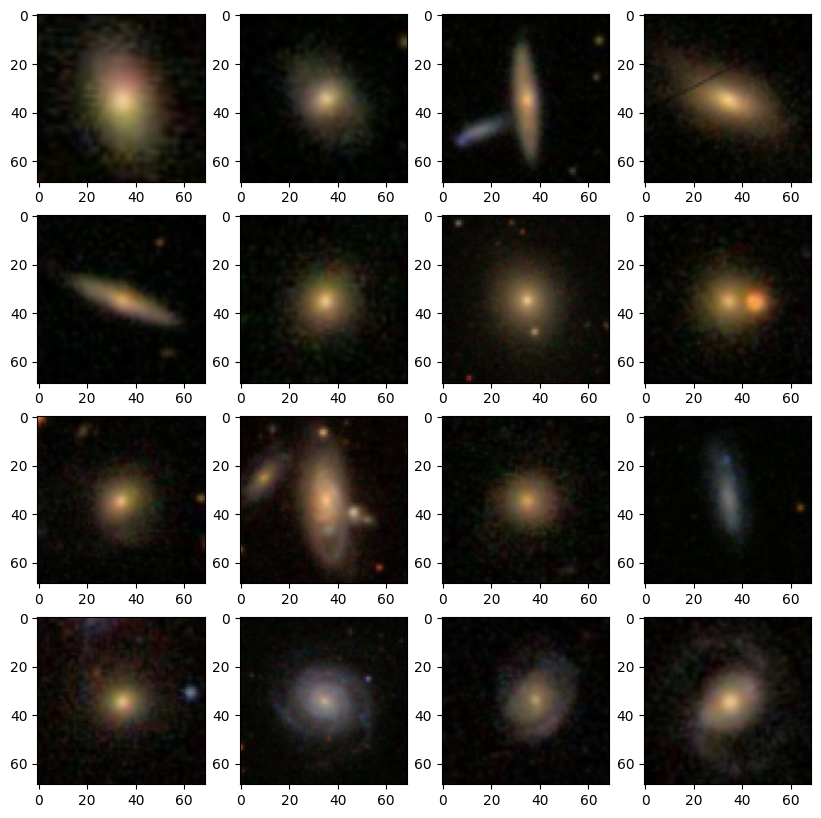

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i], cmap=plt.cm.binary)

### Exercise 1. Create train and test datasets

Divide the dataset into two datasets for:
* training: 90%
* test: 10%  

Use the `train_test_split` command from scikit_learn. Use the parameter `stratified` to ensure that the unseen test set has a representative distribution of galaxies. Do not worry for the validation dataset. We will create it in a posterior step.

More info in: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

**Task:** Create the following arrays: `X_train_full`, `X_test`, `y_train_full` and `y_test`.

In [8]:
# your code here

from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(images, labels, test_size=0.1,
                                                              random_state=42, stratify=labels)

X_train_full.shape, X_test.shape

((19606, 69, 69, 3), (2179, 69, 69, 3))

### Exercise 2. Split the train dataset into Validation and Train datasets

In the previous session we let the `.fit()`method to split the train dataset to obtain the validation dataset. This does not ensures a samples distribution in the dataset similar to the training.

Let's divide the _full dataset into two new datasets for:
* training: 80%
* validation: 20%  

Use again the `train_test_split` command from scikit_learn. Use the parameter `stratified` to ensure that the validation set has a representative distribution of galaxies.

**Task:** Create the following arrays: `X_train`, `X_val`, `y_train` and `y_val`.

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2,
                                                              random_state=42, stratify=y_train_full)

X_train.shape, X_valid.shape

((15684, 69, 69, 3), (3922, 69, 69, 3))

### Exercise 3. Initialize ImageGenerators

ImageGenerators are needed to apply data-augmentation. It can be taken advantage of them to rescale in the same step.

Remember:
* Scaling the pixel values is always needed. Use the param `rescale` to indicate de scaling value.
* As a network designer you must decide which augmentation techniques fit better to your concrete problem. Probably some of them are not useful and can produce confusion between classes.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

**Task:** Create two ImageDataGenerator one for train data `train_datagen_augmented` that rescale and apply three types of augmentation (horizontal flip, vertical and horizontal shifts). And a second generator for valid data `validation_datagen` that only rescale.

In [10]:
# your code here

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(
    rescale=1./255)

### Exercise 4. Connect ImageGenerators with data arrays

Once created the generator, it must be applied to our data arrays. Depending of the data location, different methods can be applied:

* **flow_from_directory**: if data is stored in the typical folder structure (one folder for each class).
* **flow**: when data in stored in numpy arrays in memory. Our Galaxy10 dataset is enough small to load it into a numpy array in memory.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow and https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

**Task:** Create two generators `train_generator`and `validation_generator` connected with arrays `X_train` and `X_valid` with a batchsize = 32.


In [11]:
# your code here

train_generator = train_datagen_augmented.flow(X_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(X_valid, y_valid, batch_size=32)

### Exercise 5. Building the CNN model

Remember to follow this same schema:

<br>

![picture](https://drive.google.com/uc?id=1k8aHjwHlRP3wgU-IAtpKbcvwqyvvyUwY)


The parameters of the different layers are:

A) Convolutional layer
* 12 kernels (3x3)
* Stride = 1. The kernel will be shifted pixel by pixel along the image.
* No-padding. In Tensorflow, this is indicated as padding = `valid`.

B) Pooling layer
* pool_size = 2x2
* stride = 2

C) Flatten layer  
D) Two dense layers with 500 and 100 neurons, respectively.

**Task:** create a `input_layer`, `conv_1`, `pool_1`, `flatten_layer`, `dense_1`, `dense_2` and `output_layer` with the previous parameters.

In [12]:
# your code here

input_layer = tf.keras.layers.Input(shape=(69, 69, 3))
conv_1 = tf.keras.layers.Conv2D(filters=12,               # number of filters (number of kernels)
                                kernel_size=(3, 3),       # kernel shape
                                strides=(1, 1),           # how shift kernel moving along the image
                                padding='valid',          # either to include padding or not
                                activation='relu',        # activation function
                                name='conv_1',
                                input_shape=(69, 69, 3))

pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool_1')
flatten_layer = tf.keras.layers.Flatten()
dense_1 = tf.keras.layers.Dense(units=500, activation='relu', name='dense_1')
dense_2 = tf.keras.layers.Dense(units=100, activation='relu', name='dense_2')
output_layer = tf.keras.layers.Dense(units=10, activation='softmax', name='output_layer')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Exercise 6. Dropout layer

Dropout layers can be inserted almost in any position in the network. We will add three of them after the flatten and both dense layers.

More info: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

**Task:** Create three dropout layers `do_1`, `do_2` and `do_3` with drop_rate 0.35.

In [13]:
# your code here

do_1 = tf.keras.layers.Dropout(0.35)
do_2 = tf.keras.layers.Dropout(0.35)
do_3 = tf.keras.layers.Dropout(0.35)

### Exercise 7. Join all layers in a CNN

The first step is to create a `sequential` structure to be filled with the previously created layers.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

**Task:** Collect all the previous layers in a `model`.

In [14]:
# your code here

# input shape: (69,69,3)
model = tf.keras.Sequential()

model.add(input_layer)

model.add(conv_1)
# output shape: (67,67,12)

model.add(pool_1)
# output shape: (33,33,12)

model.add(flatten_layer)
# output shape: 13068
model.add(tf.keras.layers.Dropout(0.35))

model.add(dense_1)
# output shape: 500
model.add(tf.keras.layers.Dropout(0.35))

model.add(dense_2)
# output shape: 100
model.add(tf.keras.layers.Dropout(0.35))

model.add(output_layer)
# output shape: 10


### Exercise 7. Model inspection

In the model summary we can check the three new dropout layers have been added. Of course, these layers have no parameters.

**Task:** show a summary of the network

In [15]:
# your code here

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 67, 67, 12)     │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 33, 33, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13068)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13068)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │     6,534,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,585,946 (25.12 MB)

 Trainable params: 6,585,946 (25.12 MB)

 Non-trainable params: 0 (0.00 B)

### Exercise 8. Assign loss function and optimizer

**Task:** assign the classical parameters to the network

In [16]:
# your code here

loss_function = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss=loss_function,
    optimizer=optim,
    metrics=['accuracy'])

### Exercise 9. Create an early stopping callback

Remeber EarlyStopping has two parameters:
* patience
* restore_best_weights

**Task:** Create an early stopping callback `es_callback` with patience = 4. Restore best weights when training finishes.

In [17]:
# your code here

es_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

### Exercise 10. Network training

Remember:
* Use early stopping in training via the `callbacks` parameter. It expects a list, even if there is only one callback
* Validation_split is no more needed because this task has been performed by our generators.
* Use as training and validation data the two previously created generators
* Increase the number of epochs. e.g. 30 epochs.

More info: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

**Task:** Train the model with the selected number of epochs, callback and using the generators (save the training history)

In [18]:
# your code here

history = model.fit(train_generator, validation_data=validation_generator, epochs=30,callbacks=[es_callback])

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.3433 - loss: 1.6658 - val_accuracy: 0.5036 - val_loss: 1.2044
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.4547 - loss: 1.3323 - val_accuracy: 0.4582 - val_loss: 1.2409
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.4854 - loss: 1.2646 - val_accuracy: 0.5561 - val_loss: 1.0700
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.5306 - loss: 1.1953 - val_accuracy: 0.5334 - val_loss: 1.1268
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.5344 - loss: 1.1741 - val_accuracy: 0.6316 - val_loss: 0.9641
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.5584 - loss: 1.1399 - val_accuracy: 0.6344 - val_loss: 0.9384
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.5776 - loss: 1.1029 - val_accuracy: 0.6543 - val_loss: 0.9123
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.5780 - loss: 1.1005 - val_accurac

### Exercise 11: Plot training history

It is a good practice to plot our training curves. Typically we compare the evolution of loss function (accuracy) vs epochs.

**Task:** Plot train and valid loss (and accuracy) evolution during training

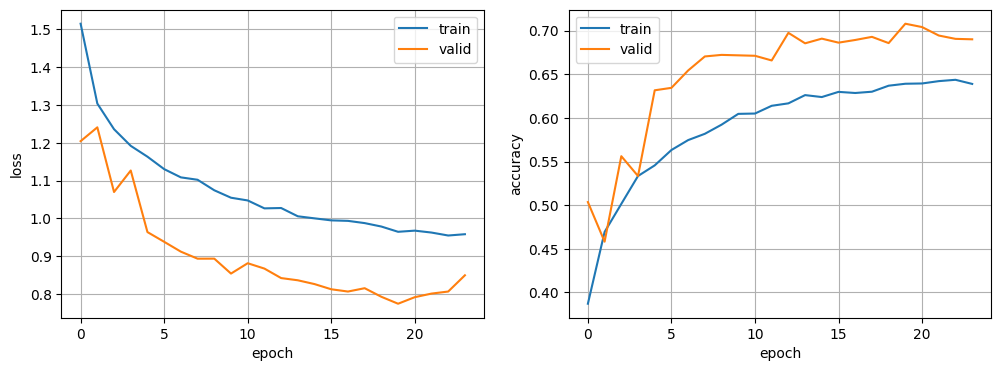

In [19]:
# your code here

df_1 = pd.DataFrame({'loss_train': history.history['loss'],
                     'loss_valid': history.history['val_loss']
                    })

df_2 = pd.DataFrame({'accuracy': history.history['accuracy'],
                   'accuracy_valid': history.history['val_accuracy']
                   })

data = [df_1, df_2]
y_labels = ['loss', 'accuracy']

f, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
for ax, y_label, df in zip(axs, y_labels, data):
    ax.plot(df, label=['train','valid'])
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel(y_label)
    ax.legend();

### Exercise 12. Evaluate model accuracy

To evaluate the model accuracy in the test dataset, first you must rescale `test_images`. You can do it in the traditional way, as in the previous practices.

**Task:** Once trained the model, obtain the accuracy of the model on the test dataset.

In [20]:
# your code here
X_test = X_test/255.0

res = model.evaluate(X_test, y_test, verbose=0)
print(f"model accuracy: {np.round(res[1],2)}")

model accuracy: 0.71


### Exercise 13: Making predictions with the model


**Task:** Inject to the model 9 images from the test dataset to obtain their probabilities.

In [21]:
# Select a few images to predict
X_new = X_test[:9]
y_true = y_test[:9]

# Make predictions
y_proba = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


**Task:** Plot the images and label them with the model's prediction and the true label. Correct predictions will be in blue, and incorrect ones in red.

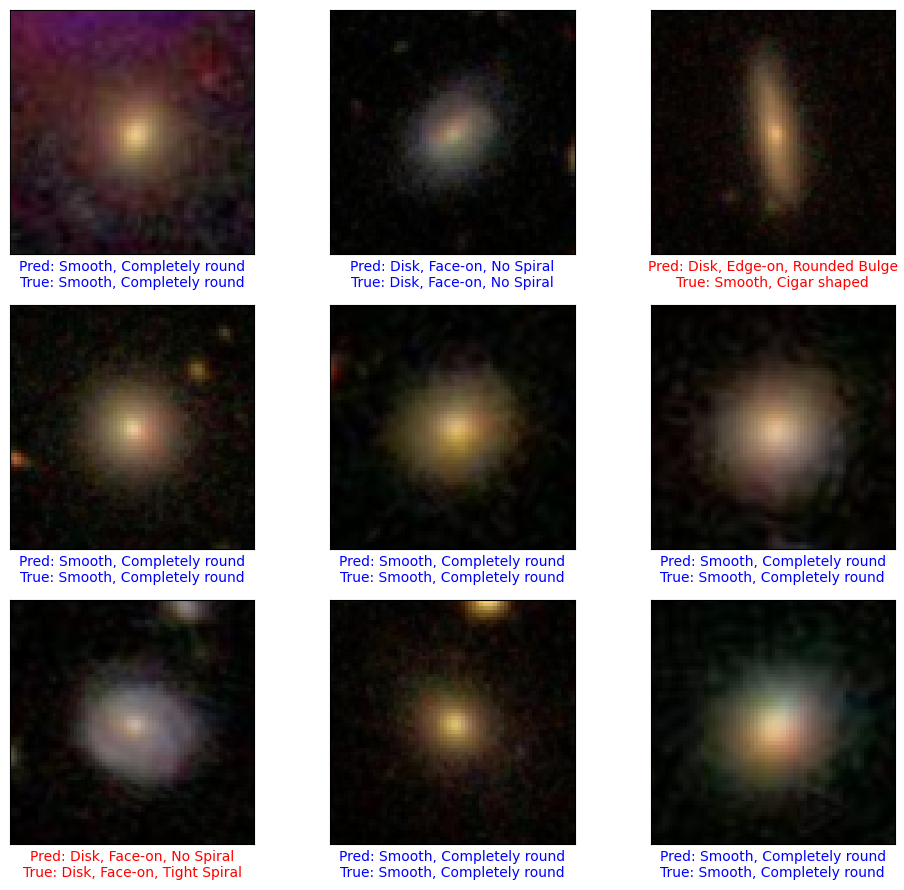

In [22]:
# your code here
y_pred = np.argmax(y_proba, axis=1)

# Plot the results
plt.figure(figsize=(10, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_new[i], cmap=plt.cm.binary)

    predicted_label = class_names[y_pred[i]]
    true_label = class_names[y_true[i]]

    color = 'blue' if y_pred[i] == y_true[i] else 'red'

    plt.xlabel(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)

plt.tight_layout()